# Derby Air Pollution Project

## Workflow

1) Get data from URL

2) Clean data

3) Plot graph per hour

4) Plot graph per day etc, do resampling

In [29]:
### Imports ###

from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import pandas as pd
from urllib.request import urlretrieve
from datetime import datetime

### Get data ###
URL_2020 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv'
URL_2019 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv'
URL_2018 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv'
URL_2017 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv' 


urlretrieve(URL_2020,'data_2020.csv')
urlretrieve(URL_2019,'data_2019.csv')
urlretrieve(URL_2018,'data_2018.csv')
urlretrieve(URL_2017,'data_2017.csv')

df_2020 = pd.read_csv('data_2020.csv',skiprows=4) # (skipping top 4 rows as they're empty)
df_2019 = pd.read_csv('data_2019.csv',skiprows=4)
df_2018 = pd.read_csv('data_2018.csv',skiprows=4)
df_2017 = pd.read_csv('data_2017.csv',skiprows=4)
unit = 'ugm^3'

### Cleaning data ###
# Issue with the data: 
# what should be "02-01-2020" and "00:00" is called "01-01-2020"  and "24:00" which Pandas doesn't like
# Need to take every instance where this happens and + 1 to the date and replace 24:00 with 00:00

def datetime_cleaner(variable):
    '''
    Function to take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00
    Also removes redundant columns
    Doesn't set the index to the datetime though
    '''
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y')
    variable['Date'] = pd.to_datetime(variable['Date'])

    # date + 1 for every 24th entry 
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value

    # cleaning up columns and data types in a really janky way
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00')
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    variable.drop(['Date','time','status','unit','status.1','unit.1','status.2','unit.2','Date String','Date Time String'],
                 axis=1,inplace=True)
    
    # making 'Date Time No Year' column
    variable['Date Time No Year'] = variable['Date Time'].dt.strftime('%d-%m %H:%M')
    
    # setting index to be the date time
    variable.index = variable['Date Time']
    
datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]

df_all = pd.concat(frames)
df_all_index = df_all.copy()
df_all_index.index = df_all_index['Date Time']

# Exploratory data analysis

Text(0.5, 1.0, '2020 Weekly Emissions')

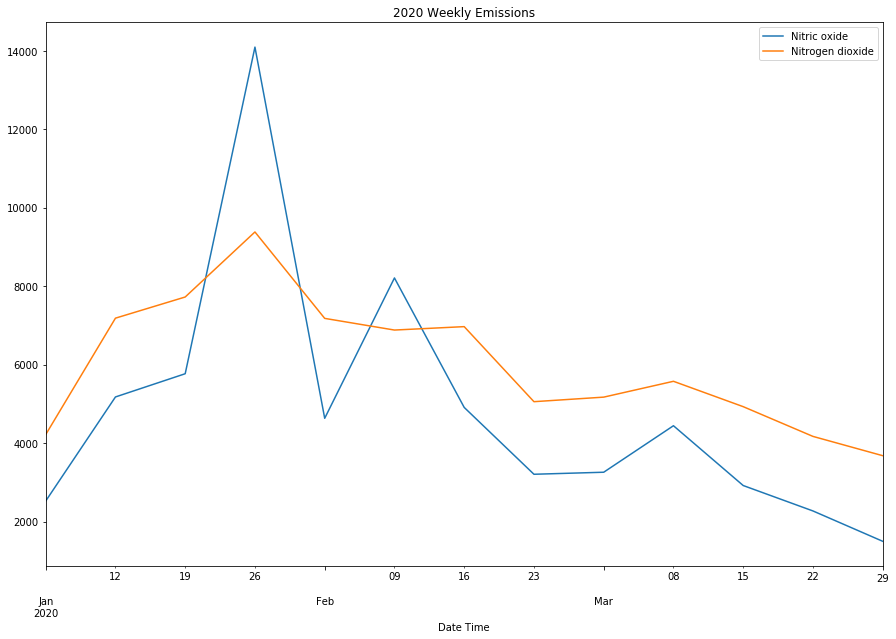

In [48]:
z = df_2020[['Nitric oxide','Nitrogen dioxide']].resample('W').sum().plot(figsize=(15,10))
z.set_title('2020 Weekly Emissions')

Text(0.5, 1.0, '2020 Monthly Emissions (Change the bloody x labels!)')

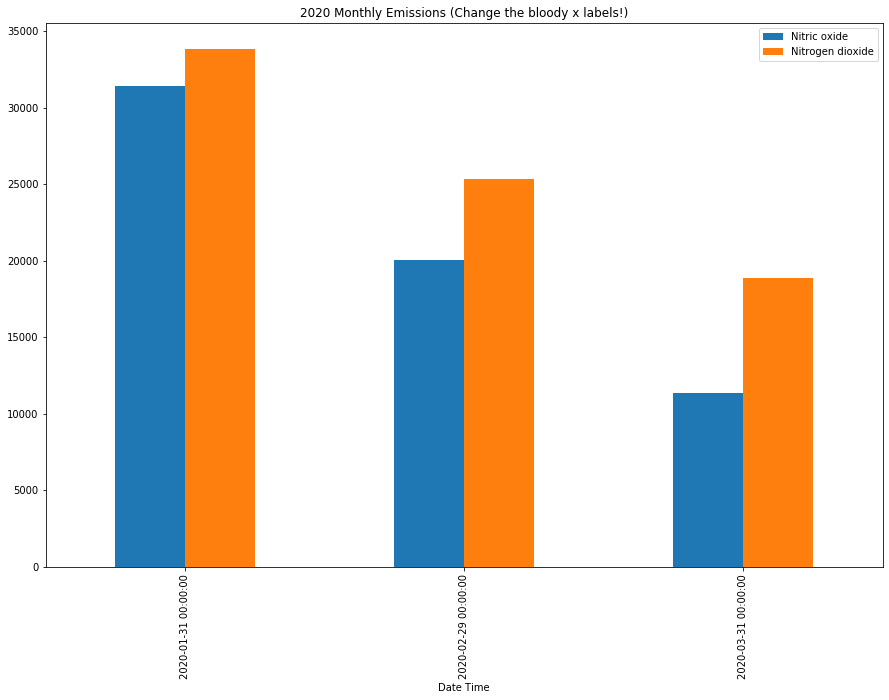

In [50]:
z = df_2020[['Nitric oxide','Nitrogen dioxide']].resample('M').sum().plot.bar(figsize=(15,10))
z.set_ylim(0)
z.set_title('2020 Monthly Emissions (Change the bloody x labels!)')

Text(0.5, 1.0, 'Monthly Emissions Since Records Began')

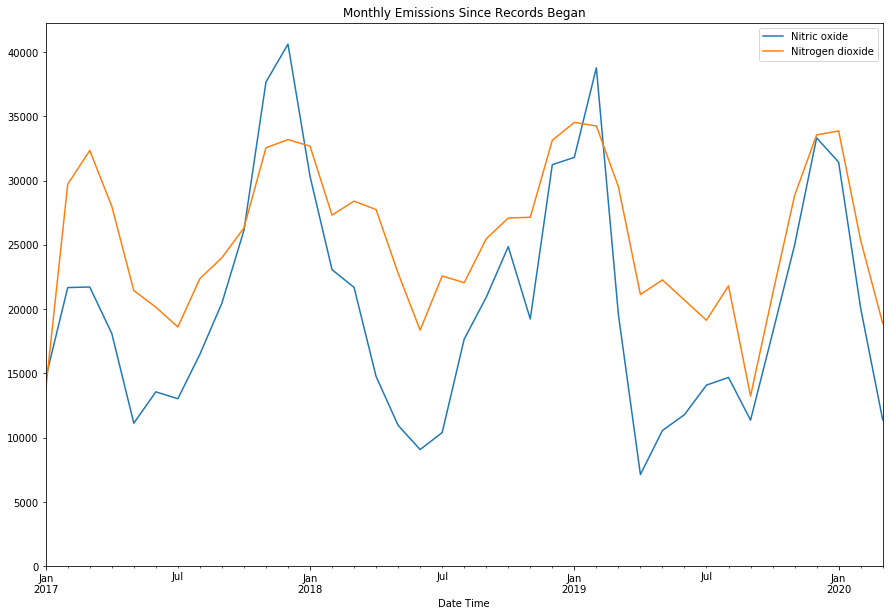

In [52]:
z = df_all_index[['Nitric oxide','Nitrogen dioxide']].resample('M').sum().plot(figsize=(15,10))
z.set_ylim(0)
z.set_title('Monthly Emissions Since Records Began')

## I want to look at March 2020

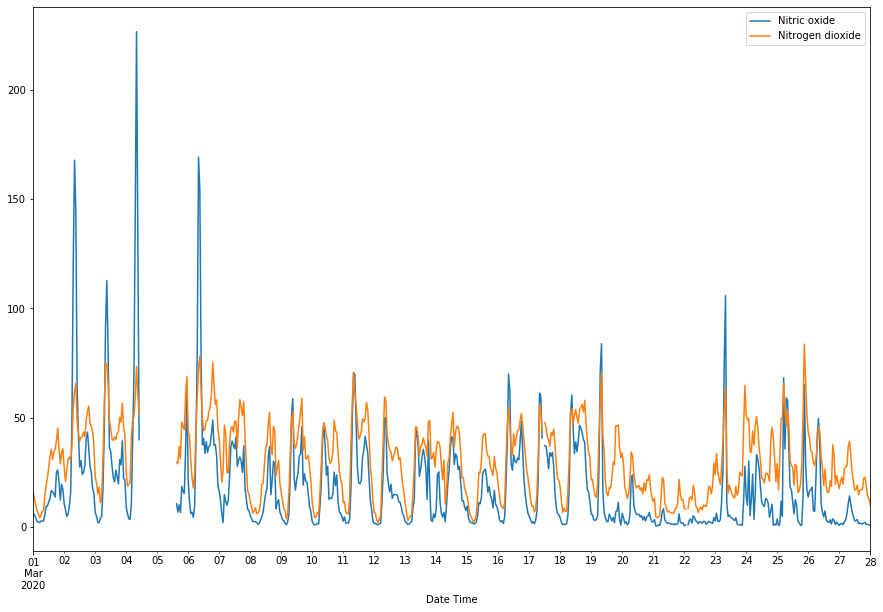

In [54]:
my_date = datetime.strptime('2020-03-01','%Y-%m-%d')
z = df_all_index[df_all_index.index>=my_date]
z[['Nitric oxide','Nitrogen dioxide']].plot(figsize=(15,10)) # FUCK that was easy!! Python is lit

In [91]:
# function to let you decide date range to plot
def plot_date_range(dateinput,resample):
    '''
    User inputs date as string in format YYYY-MM-DD
    Plot that range
    User also inputs 'hour','day','week','month' to resample accordingly 
    '''
    # date to plot from 
    dateinput_datetime = datetime.strptime(dateinput,'%Y-%m-%d')
    
    # resampling as requested
    if resample == 'hour':
        z = df_all_index[df_all_index.index>=dateinput_datetime]
        x = z[['Nitric oxide','Nitrogen dioxide']].plot(figsize=(15,10))
        x.set_title('Hourly Emissions Since {}'.format(dateinput))
    elif resample == 'day':    
        z = df_all_index[df_all_index.index>=dateinput_datetime]
        x = z[['Nitric oxide','Nitrogen dioxide']].resample('D').sum().plot(figsize=(15,10))
        x.set_title('Daily Emissions Since {}'.format(dateinput))
        
    elif resample == 'week':    
        z = df_all_index[df_all_index.index>=dateinput_datetime]
        x = z[['Nitric oxide','Nitrogen dioxide']].resample('W').sum().plot(figsize=(15,10))
        x.set_title('Weekly Emissions Since {}'.format(dateinput))
        
    elif resample == 'month':    
        z = df_all_index[df_all_index.index>=dateinput_datetime]
        x = z[['Nitric oxide','Nitrogen dioxide']].resample('M').sum().plot(figsize=(15,10))
        x.set_title('Monthly Emissions Since {}'.format(dateinput))

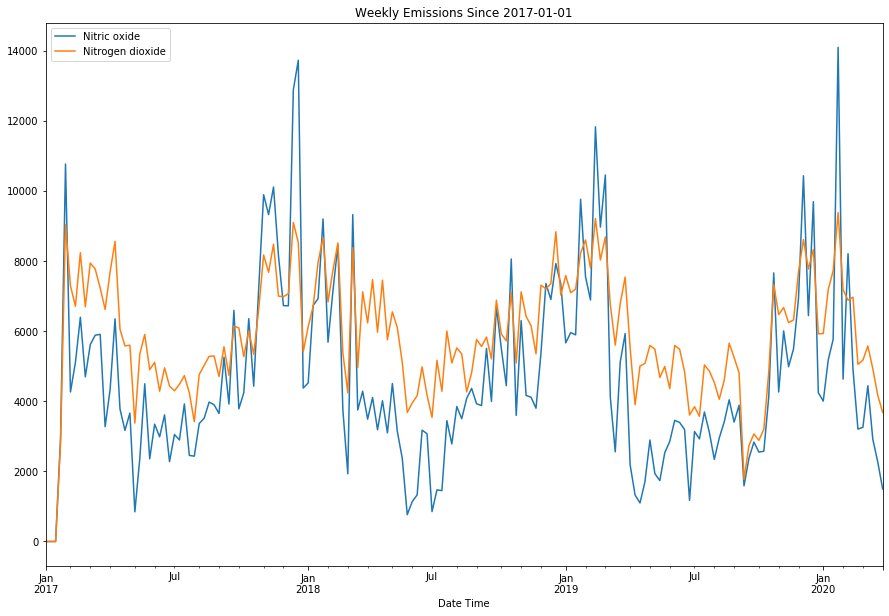

In [103]:
plot_date_range('2017-01-01','week')

# COMPARING MARCH OF EACH YEAR TO SEE WHAT CORONA HAS DONE

In [15]:
def year_comparison([databases],start_date,end_date):
    
    mask = (database['Date Time No Year'] > start_date) & (database['Date Time No Year'] <= end_date)
    df_2020_mar = df_2020.loc[mask]
    df_2020_mar2 = df_2020_mar.copy() # making a copy with the year still present for resampling
    df_2020_mar.index = df_2020_mar['Date Time No Year'] # getting rid of date time so there's no year to confuse it
    

In [ ]:
year_comparison([df_2020,df_2019,df_2018,df_2017],'03-01','03-31')

In [9]:
start_date = '03-01'
end_date = '03-31'

mask = (df_2020['Date Time No Year'] > start_date) & (df_2020['Date Time No Year'] <= end_date)
df_2020_mar = df_2020.loc[mask]
df_2020_mar2 = df_2020_mar.copy() # making a copy with the year still present for resampling
df_2020_mar.index = df_2020_mar['Date Time No Year'] # getting rid of date time so there's no year to confuse it

mask = (df_2019['Date Time No Year'] > start_date) & (df_2019['Date Time No Year'] <= end_date)
df_2019_mar = df_2019.loc[mask]
df_2019_mar2 = df_2019_mar.copy() # making a copy with the year still present for resampling
df_2019_mar.index = df_2019_mar['Date Time No Year'] # getting rid of date time so there's no year to confuse it

mask = (df_2018['Date Time No Year'] > start_date) & (df_2018['Date Time No Year'] <= end_date)
df_2018_mar = df_2018.loc[mask]
df_2018_mar2 = df_2018_mar.copy() # making a copy with the year still present for resampling
df_2018_mar.index = df_2018_mar['Date Time No Year'] # getting rid of date time so there's no year to confuse it


mask = (df_2017['Date Time No Year'] > start_date) & (df_2017['Date Time No Year'] <= end_date)
df_2017_mar = df_2017.loc[mask]
df_2017_mar2 = df_2017_mar.copy() # making a copy with the year still present for resampling
df_2017_mar.index = df_2017_mar['Date Time No Year'] # getting rid of date time so there's no year to confuse it


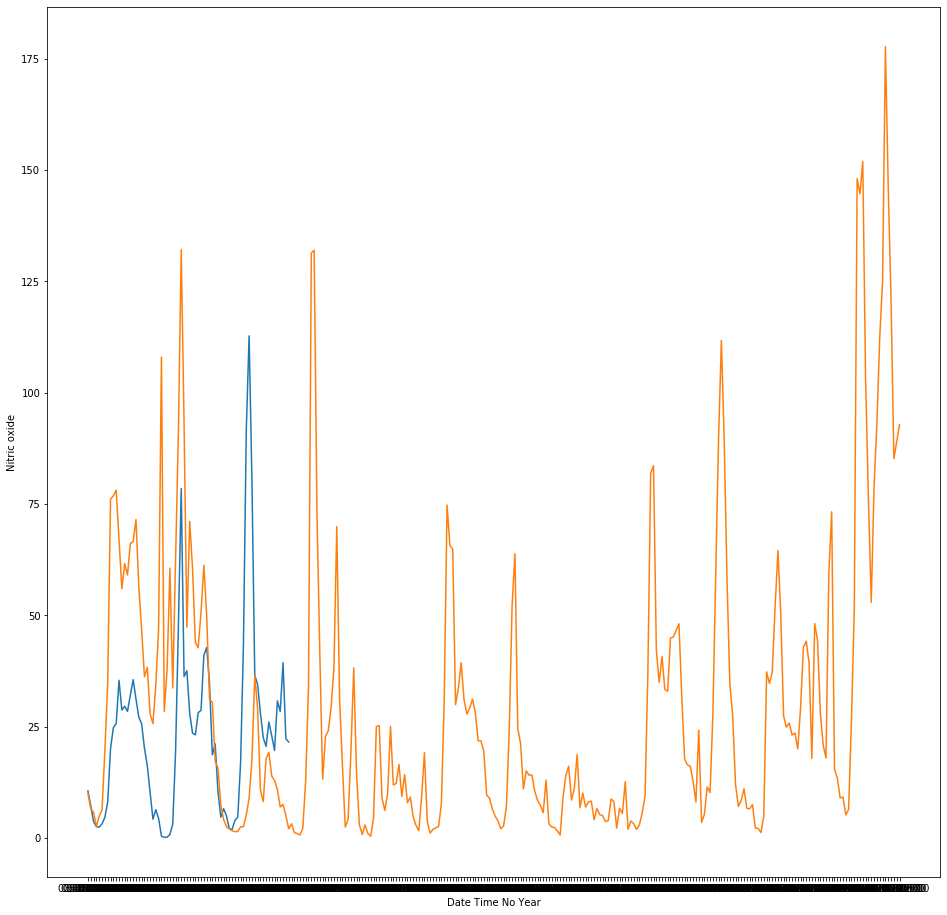

In [10]:
plt.figure(figsize=(16, 16))
sns.lineplot(x='Date Time No Year',y='Nitric oxide',data=df_2020_mar)
sns.lineplot(x='Date Time No Year',y='Nitric oxide',data=df_2019_mar)

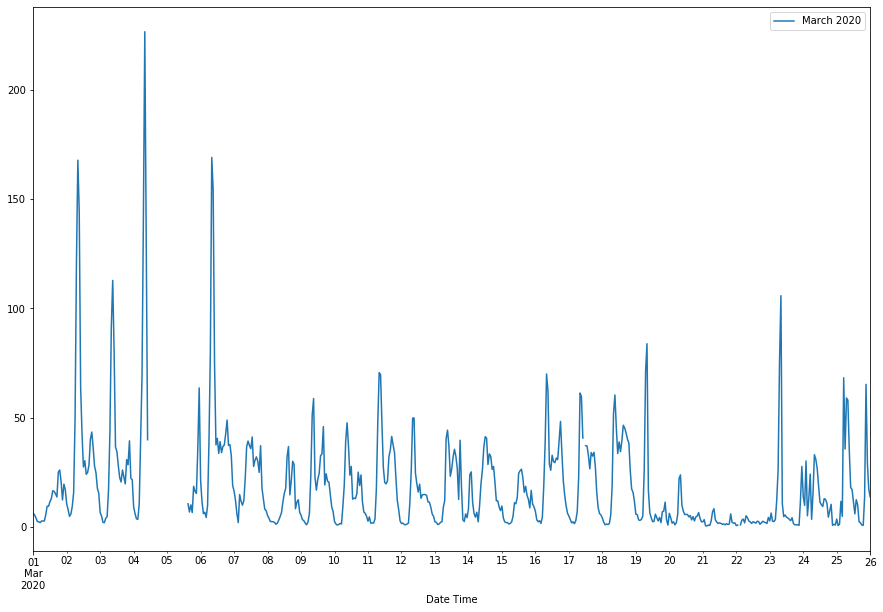

In [35]:
fig, ax = subplots()

df_2020_mar[['Date Time No Year','Nitric oxide']].plot(figsize=(15,10),ax=ax)
ax.legend(['March 2020'])


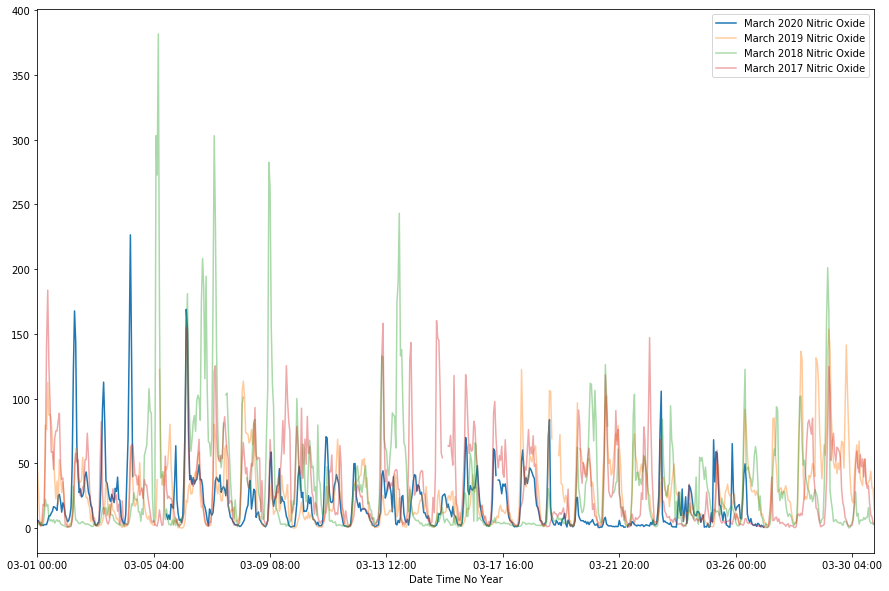

In [17]:
fig, ax = subplots()

df_2020_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax)
ax.legend(['March 2020'])
df_2019_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4)
ax.legend(['March 2020','March 2019'])
df_2018_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4)
ax.legend(['March 2020','March 2019','March 2018'])
df_2017_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4)
ax.legend(['March 2020 Nitric Oxide','March 2019 Nitric Oxide','March 2018 Nitric Oxide','March 2017 Nitric Oxide'])


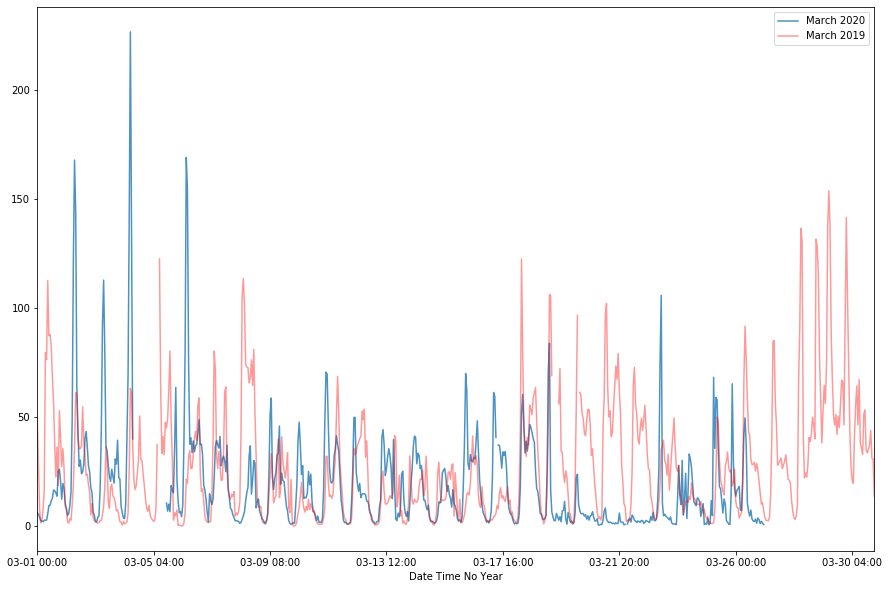

In [24]:
fig, ax = subplots()

df_2020_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.8)
ax.legend(['March 2020'])
df_2019_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4,color='red',ls='-')
ax.legend(['March 2020','March 2019'])

In [14]:
# resampling
df_2020_mar_day =df_2020_mar2.resample('D').sum()
df_2020_mar_day['Date Time No Year'] = df_2020_mar_day.index.strftime('%m-%d %H:%M')
df_2020_mar_day_noyear = df_2020_mar_day.copy()
df_2020_mar_day_noyear.index = df_2020_mar_day_noyear['Date Time No Year'] # getting rid of date time so there's no year to confuse it

df_2019_mar_day =df_2019_mar2.resample('D').sum()
df_2019_mar_day['Date Time No Year'] = df_2019_mar_day.index.strftime('%m-%d %H:%M')
df_2019_mar_day_noyear = df_2019_mar_day.copy()
df_2019_mar_day_noyear.index = df_2019_mar_day_noyear['Date Time No Year'] # getting rid of date time so there's no year to confuse it

df_2018_mar_day =df_2018_mar2.resample('D').sum()
df_2018_mar_day['Date Time No Year'] = df_2018_mar_day.index.strftime('%m-%d %H:%M')
df_2018_mar_day_noyear = df_2018_mar_day.copy()
df_2018_mar_day_noyear.index = df_2018_mar_day_noyear['Date Time No Year'] # getting rid of date time so there's no year to confuse it

df_2017_mar_day =df_2017_mar2.resample('D').sum()
df_2017_mar_day['Date Time No Year'] = df_2017_mar_day.index.strftime('%m-%d %H:%M')
df_2017_mar_day_noyear = df_2017_mar_day.copy()
df_2017_mar_day_noyear.index = df_2017_mar_day_noyear['Date Time No Year'] # getting rid of date time so there's no year to confuse it

Text(0.5, 0, 'Date')

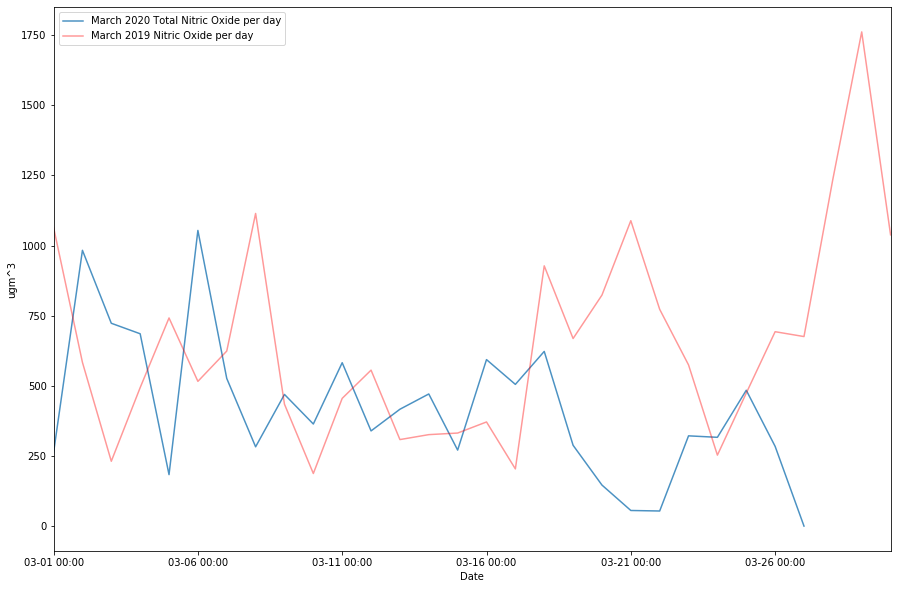

In [29]:
fig, ax = subplots()

df_2020_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.8)
ax.legend(['March 2020 Total Nitric Oxide per day'])
df_2019_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4,color='red',ls='-')
ax.legend(['March 2020 Total Nitric Oxide per day','March 2019 Nitric Oxide per day'])
ax.set_ylabel(unit)
ax.set_xlabel('Date')
#ax.set_xticks(np.arange(len(df_2019_mar_day_noyear)))
#plt.xticks(rotation=90)

Text(0.5, 1.0, 'Total Nitric Oxide Per Day (ugm^3) in March 2020 vs 2019 vs 2018 vs 2017')

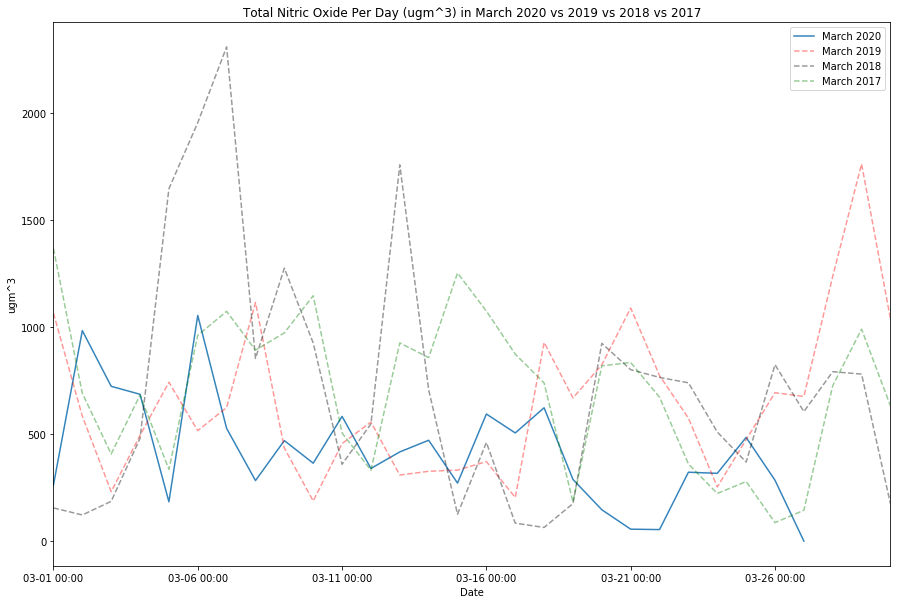

In [40]:
fig, ax = subplots()

df_2020_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.9)
df_2019_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4,color='red',ls='--')
df_2018_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4,color='black',ls='--')
df_2017_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4,color='green',ls='--')
ax.legend(['March 2020',
           'March 2019',
          'March 2018',
           'March 2017'])
ax.set_ylabel(unit)
ax.set_xlabel('Date')
ax.set_title('Total Nitric Oxide Per Day (ugm^3) in March 2020 vs 2019 vs 2018 vs 2017')
#ax.set_xticks(np.arange(len(df_2019_mar_day_noyear)))
#plt.xticks(rotation=90)